# Interconnect - Plano de Trabalho

## Objetivo do Projeto
Prever a rotatividade de clientes da operadora Interconnect, para que possam ser implementadas estratégias de retenção, como promoções e ofertas de planos personalizados.

## Fontes de Dados
- **contract.csv**: Informações sobre contratos de clientes.
- **personal.csv**: Dados pessoais dos clientes.
- **internet.csv**: Informações sobre os serviços de internet.
- **phone.csv**: Informações sobre os serviços de telefonia.

## Público-Alvo
Equipes de marketing e retenção de clientes.

## Estrutura do Projeto

### 1. Entendimento do problema e coleta de dados
- Reunir e explorar os quatro arquivos para compreender o conteúdo e definir as variáveis-chave.

    O que observar:

    - contract.csv: Deve conter informações como customerID, duração do contrato, método de pagamento e status de churn.
    - personal.csv: Deve conter variáveis como gênero, idade e região.
    - internet.csv: Provavelmente tem informações sobre os tipos de serviços de internet utilizados (DSL, fibra óptica) e serviços adicionais (antivírus, segurança online).
    - phone.csv: Possivelmente contém dados sobre o uso de telefone, número de linhas, etc.


In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Carregar os arquivos
contract = pd.read_csv('datasets/contract.csv')
personal = pd.read_csv('datasets/personal.csv')
internet = pd.read_csv('datasets/internet.csv')
phone = pd.read_csv('datasets/phone.csv')

# Função para converter camelCase ou PascalCase para snake_case, tratando 'ID' corretamente
def camel_to_snake(name):
    # Primeiro, substituímos casos como "ID" por "Id" para evitar múltiplos underscores
    # Corrigir casos de "ID" no final da string
    name = re.sub(r'ID$', 'Id', name)
    # Substituir as letras maiúsculas por underscore seguido da letra minúscula
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

# Aplicar a função aos nomes das colunas
def snake_case_columns(df):
    df.columns = [camel_to_snake(col) for col in df.columns]
    return df


# Aplicar a função nos datasets
contract = snake_case_columns(contract)
personal = snake_case_columns(personal)
internet = snake_case_columns(internet)
phone = snake_case_columns(phone)

# Renomear a coluna streaming_t_v para streaming_tv
internet.rename(columns={'streaming_t_v': 'streaming_tv'}, inplace=True)

# Verificar as colunas após a padronização
print("Contract Columns:", contract.columns, "\n")
print("Personal Columns:", personal.columns, "\n")
print("Internet Columns:", internet.columns, "\n")
print("Phone Columns:", phone.columns, "\n")

# Exibir as primeiras linhas de cada arquivo para entender a estrutura
print("Contract Data:")
print(contract.head(), "\n")

print("Personal Data:")
print(personal.head(), "\n")

print("Internet Data:")
print(internet.head(), "\n")

print("Phone Data:")
print(phone.head(), "\n")

Contract Columns: Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object') 

Personal Columns: Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object') 

Internet Columns: Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object') 

Phone Columns: Index(['customer_id', 'multiple_lines'], dtype='object') 

Contract Data:
  customer_id  begin_date             end_date            type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  paperless_b

In [3]:
contract.info() 
personal.info()
internet.info()
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null

### 2. Preparação dos Dados
- **Limpeza**: Tratamento de valores ausentes e inconsistências.
- **Integração de Dados**: Mesclar os arquivos usando o `customerID` para formar uma base de dados consolidada.
- **Engenharia de Atributos**: Criar novas variáveis a partir das informações contratuais e serviços utilizados (por exemplo, número de serviços assinados, tempo de contrato).

#### Contract.csv

Com relação aos tipos de dados no arquivo `contract.csv`, podemos observar que as colunas `begin_date` e `end_date` devem ser tratadas como datas, e a coluna `total_charges`, que está representada como texto (provavelmente devido a valores ausentes ou inválidos), deve ser convertida para numérica. 

Passos para Ajustar os Tipos de Dados:

- Converter as Colunas de Data (begin_date e end_date) para o tipo datetime.
- Converter a Coluna total_charges para o tipo numérico, tratando possíveis valores ausentes ou inválidos.
- Verificar a Coluna monthly_charges para garantir que já esteja no formato numérico.

In [4]:
# Converter begin_date e end_date para datetime
contract['begin_date'] = pd.to_datetime(
    contract['begin_date'], errors='coerce')
contract['end_date'] = pd.to_datetime(contract['end_date'], errors='coerce')

# Converter total_charges para numérico, substituindo valores inválidos por NaN
contract['total_charges'] = pd.to_numeric(
    contract['total_charges'], errors='coerce')

# Verificar os tipos de dados após a conversão
print(contract.dtypes)

# Exibir possíveis valores ausentes em total_charges após a conversão
print(contract['total_charges'].isna().sum(),
      "missing values in total_charges")

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object
11 missing values in total_charges


Passos para Verificação:
- Verificar dados ausentes (nulos): Identificar se há valores NaN nas colunas.
- Verificar valores duplicados: Verificar se há registros duplicados com base na coluna customer_id ou no conjunto completo de colunas.

In [5]:
# Verificar valores ausentes (nulos) por coluna
missing_values = contract.isnull().sum()
print("Valores Ausentes:\n", missing_values)

# Verificar se existem registros duplicados
duplicates = contract.duplicated().sum()
print("\nRegistros Duplicados no Conjunto de Dados:", duplicates)

# Verificar se há customer_id duplicados (ID de cliente único)
duplicated_customers = contract['customer_id'].duplicated().sum()
print("\nCustomer IDs Duplicados:", duplicated_customers)

Valores Ausentes:
 customer_id             0
begin_date              0
end_date             5174
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
dtype: int64

Registros Duplicados no Conjunto de Dados: 0

Customer IDs Duplicados: 0


Os resultados da verificação de dados faltantes mostram que:

- **begin_date:** 0 valores ausentes (tudo preenchido).
- **end_date:** 5174 valores ausentes, o que indica que essa coluna pode ter muitos registros sem data de término, possivelmente para contratos que ainda estão em vigor.
- **type:** 0 valores ausentes.
- **paperless_billing:** 0 valores ausentes.
- **payment_method:** 0 valores ausentes.
- **monthly_charges:** 0 valores ausentes.
- **total_charges:** 11 valores ausentes, que podem precisar de atenção.

Tratar Valores Ausentes:

- **end_date:**
Considerar que o valor ausente indica que o cliente ainda está ativo. Substituiremos esses valores ausentes por uma data futura padrão ('2099-12-31') que indicará que cliente ainda está ativo.
- **total_charges:**
Por ser uma quantidade muito baixa com relação ao conjunto de dados iremos excluir as linhas.

In [6]:
# Tratar valores ausentes em end_date
contract['end_date'].fillna(pd.Timestamp('2099-12-31'), inplace=True)  # Define uma data padrão

# Excluir linhas com valores ausentes em total_charges
contract.dropna(subset=['total_charges'], inplace=True)

# Verificar novamente os dados ausentes
missing_values_after_treatment = contract.isnull().sum()
print("Valores Ausentes Após Tratamento:\n", missing_values_after_treatment)

Valores Ausentes Após Tratamento:
 customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
dtype: int64


### Personal.csv

Para analisar os dados do arquivo `personal.csv`, podemos seguir os seguintes passos:

- **Verificar valores ausentes:** Vamos verificar se existem valores ausentes nas colunas.
- **Analisar variáveis categóricas:** Identificar a distribuição das variáveis categóricas, como gender, partner, e dependents.
- **Analisar a variável senior_citizen:** Verificar a distribuição dos valores para entender a proporção de clientes idosos (0 para não idosos e 1 para idosos).

In [7]:
# Verificar valores ausentes
missing_values = personal.isnull().sum()
print("Valores Ausentes:\n", missing_values)

# Verificar tipos de dados
print("\nTipos de Dados:\n", personal.dtypes)

# Distribuição das variáveis categóricas
print("\nDistribuição de 'gender':\n", personal['gender'].value_counts())
print("\nDistribuição de 'partner':\n", personal['partner'].value_counts())
print("\nDistribuição de 'dependents':\n", personal['dependents'].value_counts())

# Análise da variável 'senior_citizen'
print("\nDistribuição de 'senior_citizen':\n", personal['senior_citizen'].value_counts())

Valores Ausentes:
 customer_id       0
gender            0
senior_citizen    0
partner           0
dependents        0
dtype: int64

Tipos de Dados:
 customer_id       object
gender            object
senior_citizen     int64
partner           object
dependents        object
dtype: object

Distribuição de 'gender':
 Male      3555
Female    3488
Name: gender, dtype: int64

Distribuição de 'partner':
 No     3641
Yes    3402
Name: partner, dtype: int64

Distribuição de 'dependents':
 No     4933
Yes    2110
Name: dependents, dtype: int64

Distribuição de 'senior_citizen':
 0    5901
1    1142
Name: senior_citizen, dtype: int64


1. Valores Ausentes:

    Não há valores ausentes em nenhuma das colunas.

2. Tipos de Dados:
    - customer_id: object (ideal, pois é um identificador).
    - gender: object (representa as categorias).
    - senior_citizen: int64 (0 para não-idosos e 1 para idosos).
    - partner: object (representa as categorias).
    - dependents: object (representa as categorias).

3. Distribuições:
    - gender:
        - Male: 3555
        - Female: 3488
    - partner:
        - No: 3641
        - Yes: 3402
    - dependents:
        - No: 4933
        - Yes: 2110
    - senior_citizen:
        - 0 (não idosos): 5901
        - 1 (idosos): 1142

#### Interpretação:

- A proporção de gêneros é relativamente equilibrada, com um leve predomínio masculino.
- Uma maior proporção de clientes não tem parceiros e dependentes.
- A maioria dos clientes não é idosa (5901 contra 1142 idosos), o que pode influenciar na análise da rotatividade.



### Internet.csv

Análise dos dados do arquivo internet.csv:

1. **Valores Ausentes**
    - Verificar se existem valores ausentes nas colunas do conjunto de dados de internet.

2. **Tipos de Dados**
    - Analisaremos os tipos de dados para cada coluna.

3. **Distribuição de Variáveis Categóricas**
    - Vamos observar a distribuição de algumas variáveis categóricas, como internet_service, online_security, online_backup, device_protection, tech_support, streaming_t_v e streaming_movies.

In [8]:
# Verificar valores ausentes
missing_values_internet = internet.isnull().sum()
print("Valores Ausentes:\n", missing_values_internet)

# Verificar tipos de dados
data_types_internet = internet.dtypes
print("\nTipos de Dados:\n", data_types_internet)

# Distribuição das variáveis categóricas
categorical_columns = ['internet_service', 'online_security', 'online_backup', 
                       'device_protection', 'tech_support', 'streaming_tv', 
                       'streaming_movies']

for column in categorical_columns:
    distribution = internet[column].value_counts()
    print(f"\nDistribuição de '{column}':\n{distribution}")

Valores Ausentes:
 customer_id          0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
dtype: int64

Tipos de Dados:
 customer_id          object
internet_service     object
online_security      object
online_backup        object
device_protection    object
tech_support         object
streaming_tv         object
streaming_movies     object
dtype: object

Distribuição de 'internet_service':
Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

Distribuição de 'online_security':
No     3498
Yes    2019
Name: online_security, dtype: int64

Distribuição de 'online_backup':
No     3088
Yes    2429
Name: online_backup, dtype: int64

Distribuição de 'device_protection':
No     3095
Yes    2422
Name: device_protection, dtype: int64

Distribuição de 'tech_support':
No     3473
Yes    2044
Name: tech_support, dtype: int64

Distribuição de 'streaming_tv':
No 

1. Valores Ausentes:
    - Não há valores ausentes em nenhuma das colunas, o que é ótimo para a integridade dos dados.

2. Tipos de Dados:
    - Todos os tipos de dados estão corretos:

        - customer_id: object (ideal para identificadores)
        - internet_service: object (representa tipos de serviços)
        - As demais colunas são categóricas, o que é apropriado.
3. Distribuições:
    - internet_service:
        - Fiber optic: 3096
        - DSL: 2421
    - online_security:
        - No: 3498
        - Yes: 2019
    - online_backup:
        - No: 3088
        - Yes: 2429
    - device_protection:
        - No: 3095
        - Yes: 2422
    - tech_support:
        - No: 3473
        - Yes: 2044
    - streaming_tv:
        - No: 2810
        - Yes: 2707
    - streaming_movies:
        - No: 2785
        - Yes: 2732

#### Interpretação:

- **Serviço de Internet:** A maioria dos clientes utiliza serviço de fibra óptica, indicando uma preferência por conexões mais rápidas.
- **Segurança e Suporte:** Um número considerável de clientes não opta por serviços de segurança online e suporte técnico, o que pode ser uma oportunidade para a Interconnect oferecer promoções.
- **Streaming:** A distribuição dos serviços de streaming é relativamente equilibrada, com uma ligeira preferência pela inclusão desses serviços.

### Phone.csv

1. Tipos de Dados:

    - **customer_id:** Código único de cada cliente.
    - **multiple_lines:** Indica se o cliente tem múltiplas linhas telefônicas.

2. Passos para análise:

    - Valores Ausentes: Verificar se há dados ausentes ou nulos.
    - Distribuição da Coluna multiple_lines: Entender quantos clientes possuem ou não múltiplas linhas.



In [9]:
# 1. Verificar se há valores ausentes
missing_values_phone = phone.isnull().sum()
print("Valores Ausentes:")
print(missing_values_phone)

# 2. Exibir os tipos de dados de cada coluna
print("\nTipos de Dados:")
print(phone.dtypes)

# 3. Distribuição da coluna 'multiple_lines'
multiple_lines_distribution = phone['multiple_lines'].value_counts()
print("\nDistribuição da coluna 'multiple_lines':")
print(multiple_lines_distribution)

Valores Ausentes:
customer_id       0
multiple_lines    0
dtype: int64

Tipos de Dados:
customer_id       object
multiple_lines    object
dtype: object

Distribuição da coluna 'multiple_lines':
No     3390
Yes    2971
Name: multiple_lines, dtype: int64


1. Valores Ausentes:

    - Nenhuma coluna tem valores ausentes, o que indica que os dados estão completos para análise.

2. Tipos de Dados:

    - **customer_id:** Tipo object (texto), pois é uma identificação única de cada cliente.
    - **multiple_lines:** Tipo object, representando a resposta "Yes" ou "No" para a presença de múltiplas linhas telefônicas.

3. Distribuição da Coluna multiple_lines:

    - **No:** 3.390 clientes não possuem múltiplas linhas telefônicas.
    - **Yes:** 2.971 clientes possuem múltiplas linhas telefônicas.

Aproximadamente 53% dos clientes não possuem múltiplas linhas, enquanto 47% possuem. A distribuição é relativamente equilibrada, o que pode ser relevante para a análise posterior, como avaliar a relação entre múltiplas linhas e churn (rotatividade).

- Próximos passos: contract

    Com base nessa exploração inicial, iremos identificar variáveis-chave, como:

    - Variável-alvo: Churn (rotatividade de clientes).
    - Possíveis preditores: Duração do contrato, método de pagamento, uso de serviços de internet, e uso de telefone.

- Próximos Passos: personal
    - Transformar Variáveis Categóricas: Para preparar os dados para modelagem, pode ser necessário codificar as variáveis categóricas (por exemplo, gender, partner, dependents).
    - Unir os Dados: Podemos começar a unir os dados de personal.csv com os de contract.csv para análises mais profundas sobre a rotatividade dos clientes.

- Próximos Passos: internet
    - Transformar Variáveis Categóricas: Como nas etapas anteriores, você pode querer codificar essas variáveis para que possam ser utilizadas em um modelo preditivo.
    - Unir Dados: Unir os dados de internet.csv com os de contract.csv e personal.csv para criar um conjunto de dados mais completo para a análise de churn.

- Próximos Passos: phone

    - Próximos passos podem incluir a análise cruzada desses dados com outras informações, como serviços de internet ou dados pessoais, para ver se há alguma correlação com a rotatividade.

### 3. Análise Exploratória de Dados (EDA)

- Unir os dados de todos os dataframes utilizando a coluna `customer_id` como chave.

In [10]:
# Unir personal.csv com contract.csv
merged_data = pd.merge(contract, personal, on='customer_id', how='left')

# Unir internet.csv com o dataframe combinado
merged_data = pd.merge(merged_data, internet, on='customer_id', how='left')

# Unir phone.csv com o dataframe combinado
merged_data = pd.merge(merged_data, phone, on='customer_id', how='left')

# Exibir as primeiras linhas do dataframe final combinado
print(merged_data.head())

# Verificar se há dados faltantes no dataframe combinado
missing_values = merged_data.isnull().sum()

# Exibir as colunas com dados faltantes
print("Valores faltantes por coluna:")
print(missing_values[missing_values > 0])

  customer_id begin_date   end_date            type paperless_billing  \
0  7590-VHVEG 2020-01-01 2099-12-31  Month-to-month               Yes   
1  5575-GNVDE 2017-04-01 2099-12-31        One year                No   
2  3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
3  7795-CFOCW 2016-05-01 2099-12-31        One year                No   
4  9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   

              payment_method  monthly_charges  total_charges  gender  \
0           Electronic check            29.85          29.85  Female   
1               Mailed check            56.95        1889.50    Male   
2               Mailed check            53.85         108.15    Male   
3  Bank transfer (automatic)            42.30        1840.75    Male   
4           Electronic check            70.70         151.65  Female   

   senior_citizen partner dependents internet_service online_security  \
0               0     Yes         No              DSL  

Possível interpretação dos Valores Faltantes

Os dados mostram valores faltantes nas colunas relacionadas a internet e telefone:

- **internet_service, online_security, online_backup, device_protection, tech_support, streaming_tv, streaming_movies:** Essas colunas apresentam 1526 valores faltantes, o que indica que 1526 clientes podem não ter serviços de internet associados, explicando o motivo da ausência de dados nessas colunas.

- **multiple_lines:** Essa coluna tem 682 valores faltantes, sugerindo que esses clientes talvez não tenham o serviço de "múltiplas linhas" ou, mais provavelmente, não tenham um serviço de telefone associado.

Solução Proposta

- **Tratar os dados faltantes de internet:** Preencher os valores ausentes nas colunas relacionadas ao serviço de internet com "No internet", uma vez que esses clientes provavelmente não possuem internet.

- **Tratar os dados faltantes de múltiplas linhas:** Para a coluna multiple_lines, pode-se assumir que os valores ausentes correspondem a clientes que não têm telefone, logo a uma estratégia seria preencher esses valores com "No phone".

In [11]:
internet_columns = ['internet_service', 'online_security', 'online_backup',
                    'device_protection', 'tech_support', 'streaming_tv',
                    'streaming_movies']

merged_data[internet_columns] = merged_data[internet_columns].fillna(
    "No internet")

merged_data['multiple_lines'] = merged_data['multiple_lines'].fillna(
    "No phone")

# Verificar se ainda há valores faltantes
print(merged_data.isnull().sum())

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64


#### Conclusão

Preencher os valores faltantes com categorias como "No internet" e "No phone" é uma abordagem lógica que reflete a ausência desses serviços para os clientes em questão. Com essas correções, o conjunto de dados estará mais consistente para a análise de churn.

In [12]:
merged_data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2099-12-31,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No phone
1,5575-GNVDE,2017-04-01,2099-12-31,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2099-12-31,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No phone
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


A partir do novo DataFrame, há várias informações que podemos extrair e criar novas colunas com base nas colunas existentes:

- **Duração do Contrato:** Calcular a duração do contrato em meses, usando begin_date e end_date.

- **Total de Meses de Cobrança:** Para os contratos com duração indefinida (como "Month-to-month"), vamos atribuir uma duração diferente em relação aos contratos com duração fixa.

- **Valor Médio Mensal de Cobrança:** Criaremos uma coluna que calcule o valor médio mensal de cobrança, comparando total_charges com a duração do contrato.

- **Classificação de Clientes:** Criar uma coluna que classifique os clientes em categorias com base em monthly_charges, como "Baixo", "Médio" e "Alto".

- **Soma de Serviços:** Criar uma coluna que some todos os serviços de internet que o cliente possui, baseado nas colunas online_security, online_backup, device_protection, tech_support, streaming_tv e streaming_movies.

- **Status de Pagamento:** Criar uma coluna que classifique os clientes como "Atrasado" ou "Em dia" com base no payment_method e na comparação entre monthly_charges e total_charges.

In [13]:
# Verificar a última data na coluna end_date, exceto 2099-12-31
data_extracao = merged_data[merged_data['end_date'] != '2099-12-31']['end_date'].max()

# Converter para o tipo datetime, se necessário, e adicionar 1 dia
data_extracao = pd.to_datetime(data_extracao) + pd.Timedelta(days=1)

# Exibir a nova data de extração
print("Data de Extração com 1 dia a mais:", data_extracao)

# Definindo a data para comparação
active_end_date = pd.to_datetime('2099-12-31')

# Criar a coluna "churn" onde churn=1 para inativos e churn=0 para ativos
merged_data['churn'] = merged_data['end_date'].apply(
    lambda x: 0 if x == active_end_date else 1
).astype(int)

# Verificar o tipo da coluna churn
print(merged_data['churn'].dtype)

# 1. Calcular a duração do contrato em meses
merged_data['contract_duration'] = merged_data.apply(
    lambda row: (data_extracao - pd.to_datetime(row['begin_date'])).days / 30
    if row['end_date'] == active_end_date
    else (pd.to_datetime(row['end_date']) - pd.to_datetime(row['begin_date'])).days / 30,
    axis=1
)
merged_data['contract_duration'] = np.ceil(merged_data['contract_duration']).astype(int) # Arredondar para cima e converter para integer

# 2. Total de Meses de Cobrança para contratos Month-to-month
merged_data['total_months'] = merged_data['contract_duration'].where(
    merged_data['type'] != 'Month-to-month', 1)

# 3. Valor Médio Mensal de Cobrança
merged_data['average_monthly_charge'] = merged_data['total_charges'] / \
    merged_data['total_months']


# 4. Classificação de Clientes por Monthly Charges
bins = [0, 50, 100, float('inf')]
labels = ['Baixo', 'Médio', 'Alto']
merged_data['charge_category'] = pd.cut(
    merged_data['monthly_charges'], bins=bins, labels=labels)


# 5. Soma de Serviços
merged_data['services_count'] = (merged_data[['online_security', 'online_backup', 'device_protection',
                                 'tech_support', 'streaming_tv', 'streaming_movies']] == 'Yes').sum(axis=1)

# 6. Status de Pagamento
merged_data['payment_status'] = merged_data.apply(
    lambda x: 'Atrasado' if x['total_charges'] < (
        x['monthly_charges'] * x['total_months']) else 'Em dia',
    axis=1
)

# Converter a coluna type em numérica
merged_data['type_numeric'] = merged_data['type'].map(
    {'Month-to-month': 0, 'One year': 1, 'Two year': 2})

# Transformar as colunas "gender", "partner", e "dependents" em colunas numéricas
merged_data['gender_numeric'] = merged_data['gender'].map({'Male': 1, 'Female': 0})
merged_data['partner_numeric'] = merged_data['partner'].map({'Yes': 1, 'No': 0})
merged_data['dependents_numeric'] = merged_data['dependents'].map({'Yes': 1, 'No': 0})

# Mover a coluna "churn" para o final do DataFrame
churn_column = merged_data.pop('churn')
merged_data['churn'] = churn_column

merged_data.head()

Data de Extração com 1 dia a mais: 2020-01-02 00:00:00
int64


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,total_months,average_monthly_charge,charge_category,services_count,payment_status,type_numeric,gender_numeric,partner_numeric,dependents_numeric,churn
0,7590-VHVEG,2020-01-01,2099-12-31,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,1,29.850000,Baixo,1,Em dia,0,0,1,0,0
1,5575-GNVDE,2017-04-01,2099-12-31,One year,No,Mailed check,56.95,1889.50,Male,0,...,34,55.573529,Médio,2,Atrasado,1,1,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,1,108.150000,Médio,2,Em dia,0,1,0,0,1
3,7795-CFOCW,2016-05-01,2099-12-31,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,45,40.905556,Baixo,3,Atrasado,1,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,1,151.650000,Médio,0,Em dia,0,0,0,0,1


In [14]:
# Exibir as primeiras linhas para verificar se foram convertidos para números inteiros
print(merged_data[['begin_date', 'end_date', 'contract_duration', 'total_months']].head())

  begin_date   end_date  contract_duration  total_months
0 2020-01-01 2099-12-31                  1             1
1 2017-04-01 2099-12-31                 34            34
2 2019-10-01 2019-12-01                  3             1
3 2016-05-01 2099-12-31                 45            45
4 2019-09-01 2019-11-01                  3             1


In [15]:
# Estatísticas descritivas para colunas numéricas
numerical_stats = merged_data.describe()

# Estatísticas descritivas para colunas categóricas
categorical_stats = merged_data.describe(include='object')
categorical_stats_cat = merged_data.describe(include='category')

numerical_stats, categorical_stats, categorical_stats_cat

(       monthly_charges  total_charges  senior_citizen  contract_duration  \
 count      7032.000000    7032.000000     7032.000000        7032.000000   
 mean         64.798208    2283.300441        0.162400          32.791667   
 std          30.085974    2266.771362        0.368844          24.627712   
 min          18.250000      18.800000        0.000000           1.000000   
 25%          35.587500     401.450000        0.000000           9.000000   
 50%          70.350000    1397.475000        0.000000          29.000000   
 75%          89.862500    3794.737500        0.000000          56.000000   
 max         118.750000    8684.800000        1.000000          74.000000   
 
        total_months  average_monthly_charge  services_count  type_numeric  \
 count   7032.000000             7032.000000     7032.000000   7032.000000   
 mean      23.189562              782.557442        2.038111      0.688567   
 std       28.028559             1363.143716        1.847161      0.832

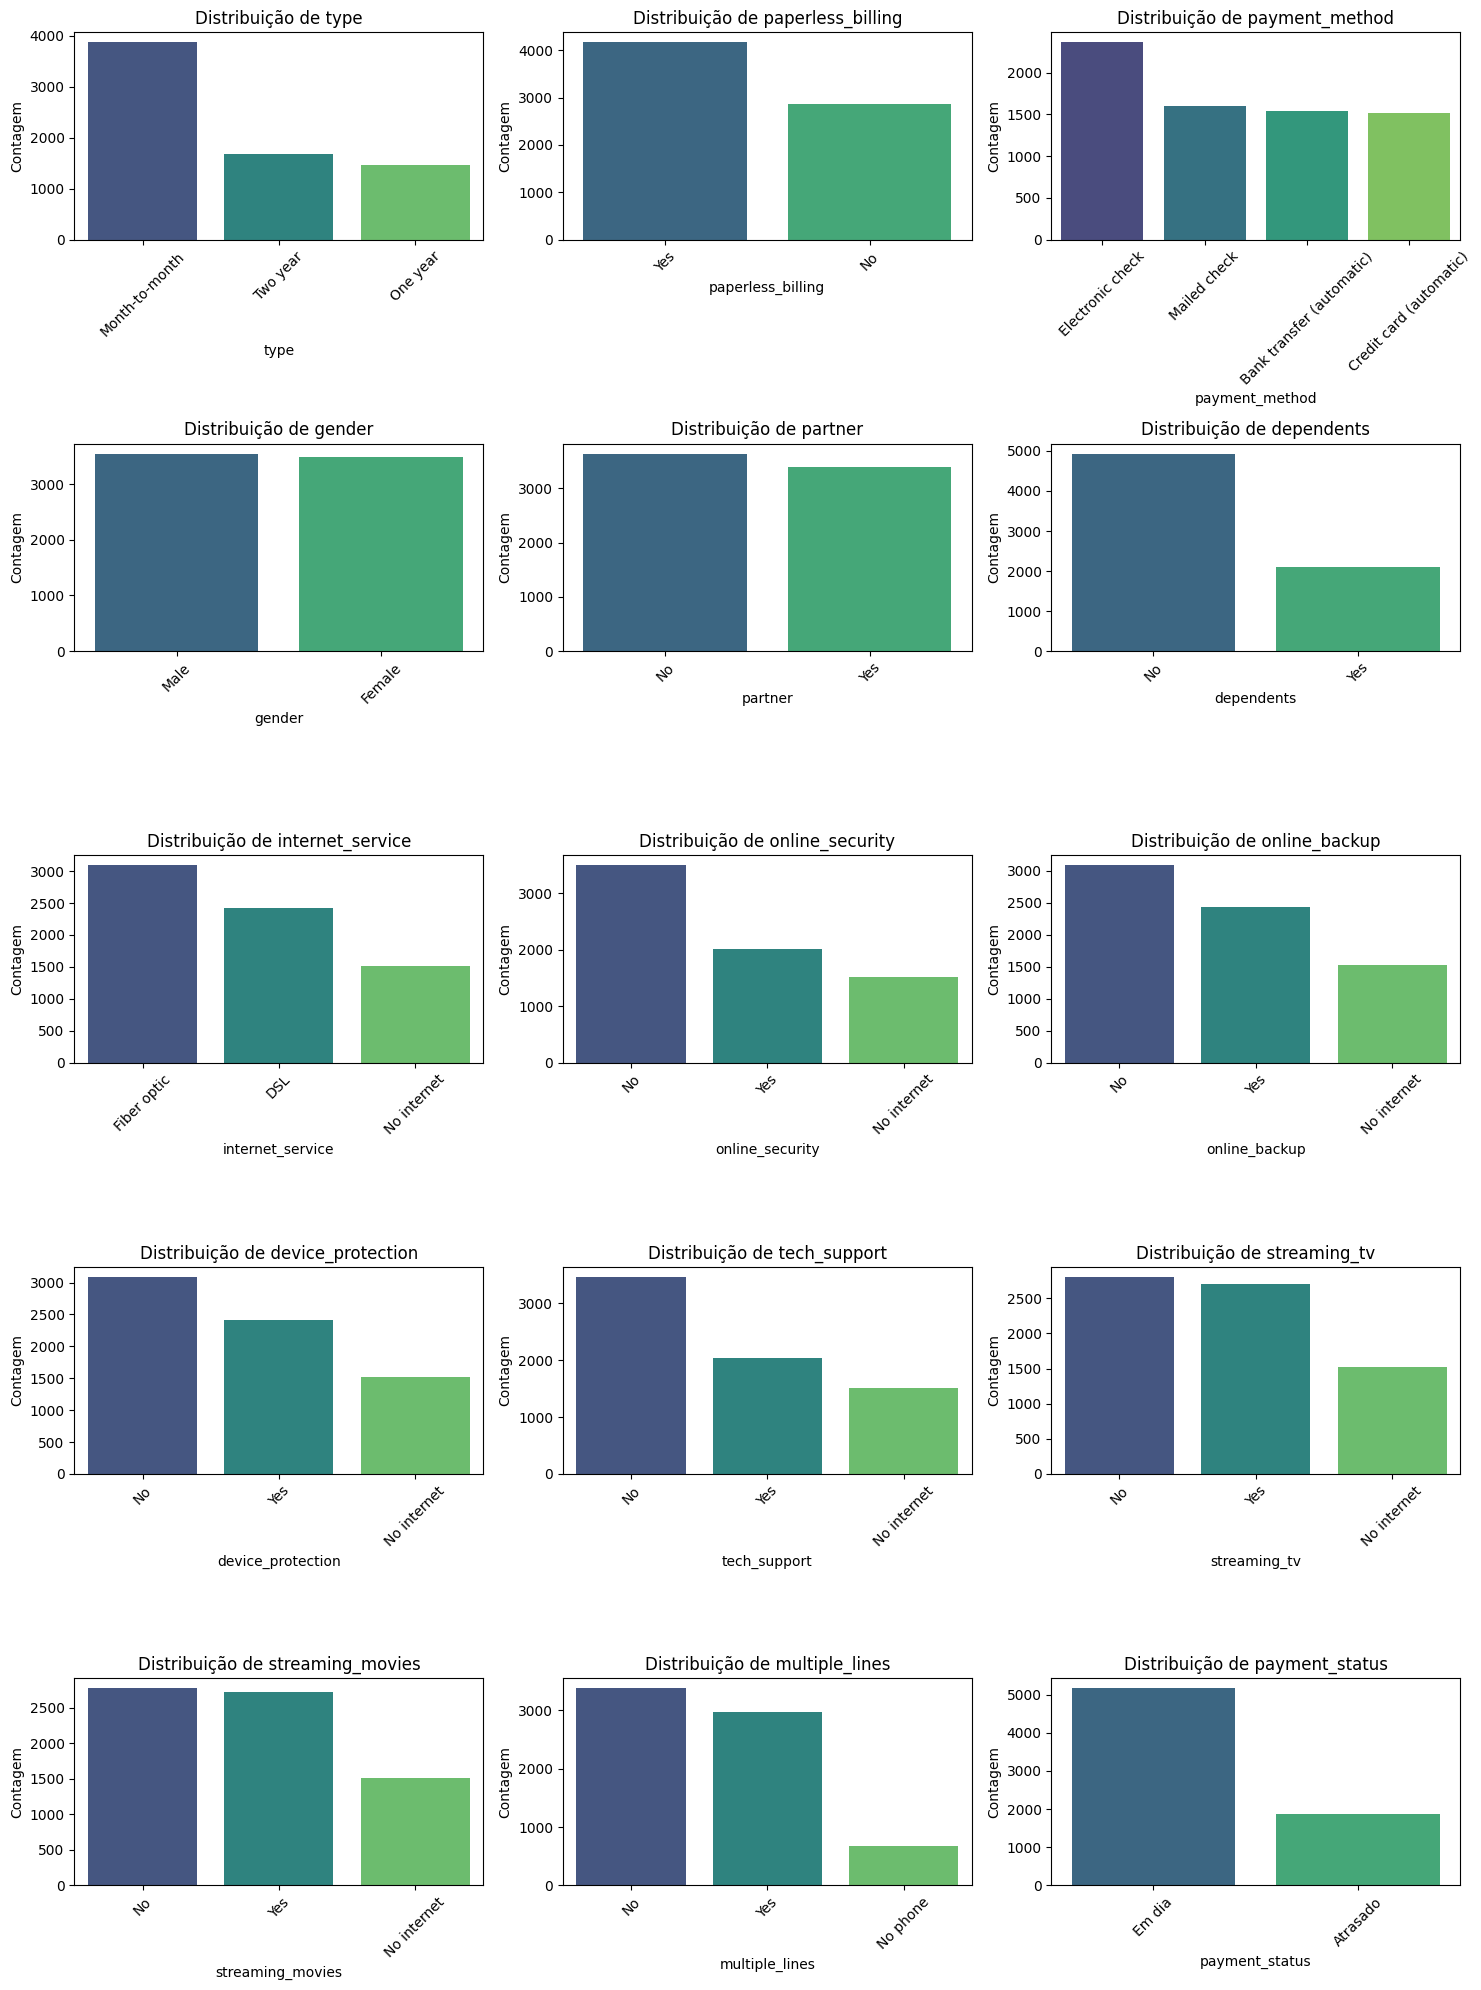

In [16]:
# Listar colunas categóricas
categorical_columns = merged_data.select_dtypes(
    include=['object', 'category']).columns

# Excluindo a coluna customer_id
categorical_columns = merged_data.select_dtypes(
    include='object').columns.tolist()
categorical_columns.remove('customer_id')

# Definir o número de gráficos em uma grade
num_cols = 3  # Número de colunas na grade
num_rows = (len(categorical_columns) + num_cols -
            1) // num_cols  # Cálculo do número de linhas

# Configurar o tamanho da figura
plt.figure(figsize=(15, num_rows * 4))

# Loop através das colunas categóricas e criar gráficos
for i, col in enumerate(categorical_columns):
    plt.subplot(num_rows, num_cols, i + 1)  # Cria um subplot
    sns.countplot(data=merged_data, x=col,
                  order=merged_data[col].value_counts().index, palette='viridis')
    plt.title(f'Distribuição de {col}')
    plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x
    plt.ylabel('Contagem')
    plt.xlabel(col)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

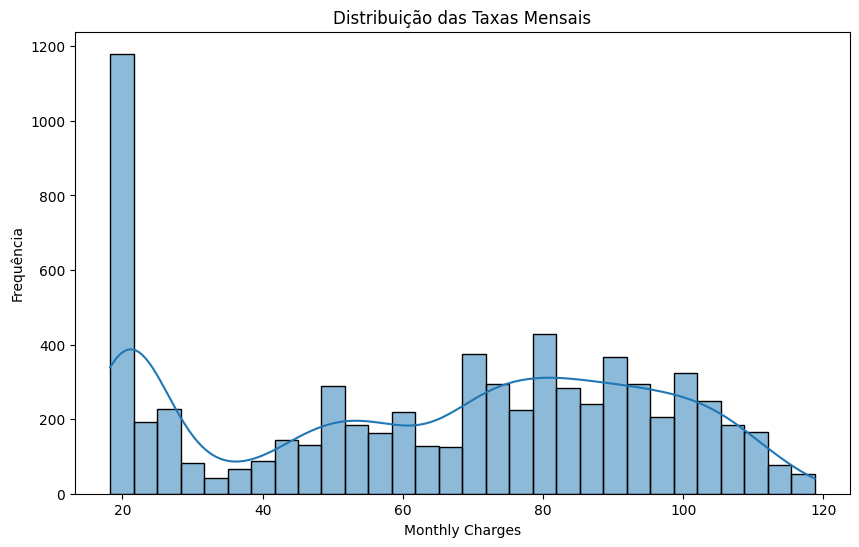

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['monthly_charges'], bins=30, kde=True)
plt.title('Distribuição das Taxas Mensais')
plt.xlabel('Monthly Charges')
plt.ylabel('Frequência')
plt.show()

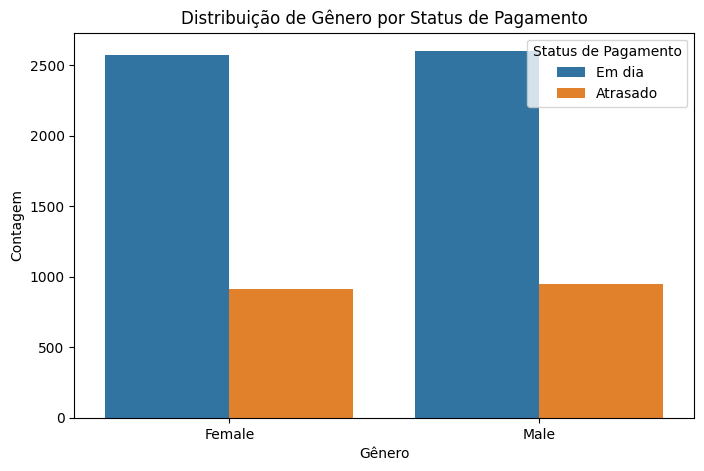

In [18]:
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='payment_status', data=merged_data)
plt.title('Distribuição de Gênero por Status de Pagamento')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.legend(title='Status de Pagamento')
plt.show()

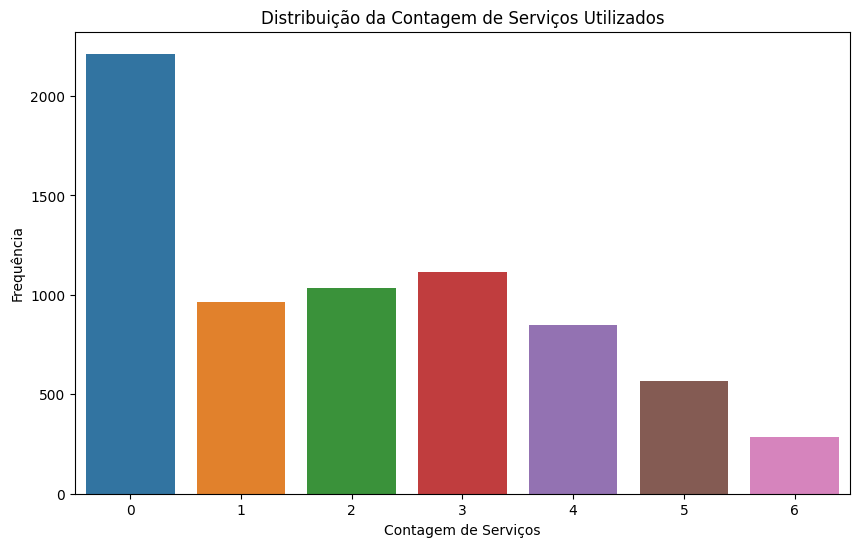

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='services_count', data=merged_data)
plt.title('Distribuição da Contagem de Serviços Utilizados')
plt.xlabel('Contagem de Serviços')
plt.ylabel('Frequência')
plt.show()

Matriz de Correlação:
                        monthly_charges  total_charges  senior_citizen  \
monthly_charges                1.000000       0.651065        0.219874   
total_charges                  0.651065       1.000000        0.102411   
senior_citizen                 0.219874       0.102411        1.000000   
contract_duration              0.251665       0.827645        0.018145   
total_months                   0.087893       0.635191       -0.085276   
average_monthly_charge         0.371485       0.261838        0.203658   
services_count                 0.724768       0.746101        0.067527   
type_numeric                  -0.072739       0.450306       -0.141820   
gender_numeric                -0.013779       0.000048       -0.001819   
partner_numeric                0.097825       0.319072        0.016957   
dependents_numeric            -0.112343       0.064653       -0.210550   
churn                          0.192858      -0.199484        0.150541   

               

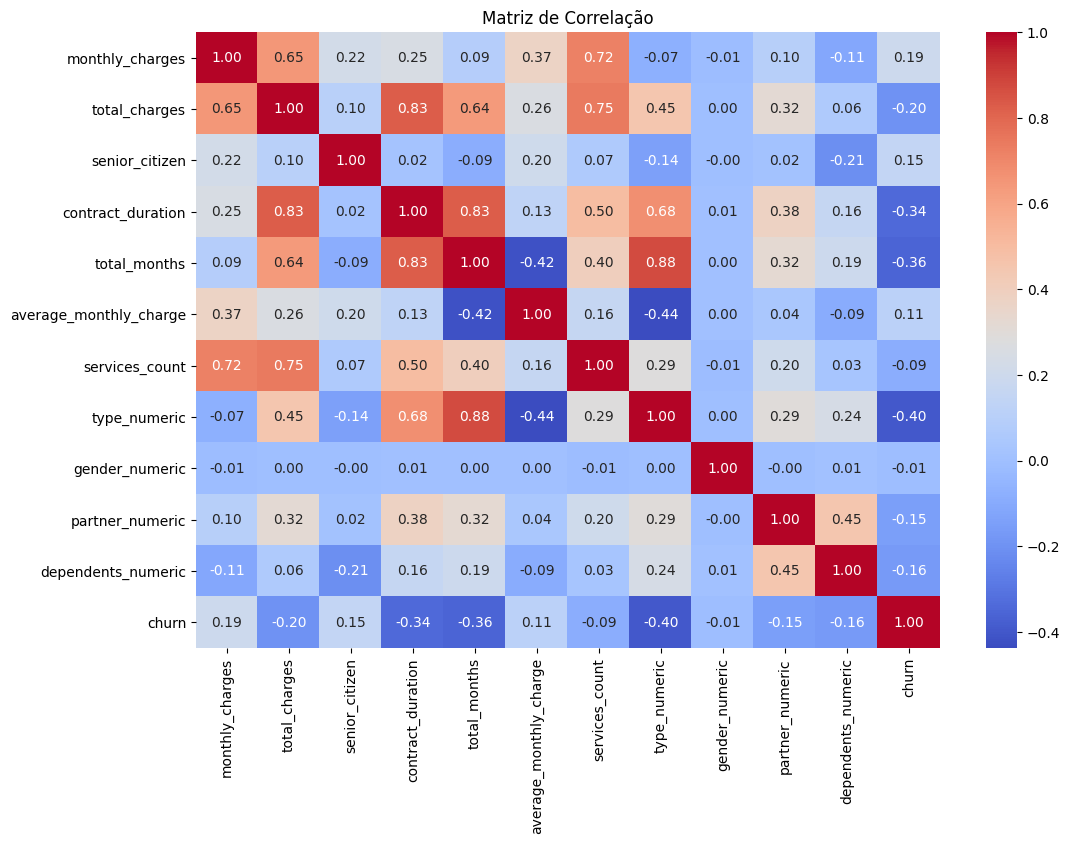

In [20]:
# Selecionar apenas as colunas numéricas
numerical_data = merged_data.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação
correlation_matrix = numerical_data.corr()

# Imprimir a matriz de correlação
print("Matriz de Correlação:")
print(correlation_matrix)

# Plotar a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

Correlação com a coluna churn:
monthly_charges           0.192858
total_charges            -0.199484
senior_citizen            0.150541
contract_duration        -0.339587
total_months             -0.356683
average_monthly_charge    0.113929
services_count           -0.087882
type_numeric             -0.396150
gender_numeric           -0.008545
partner_numeric          -0.149982
dependents_numeric       -0.163128
Name: churn, dtype: float64


/tmp/ipykernel_141/1432960741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_data['churn'] = merged_data['churn']


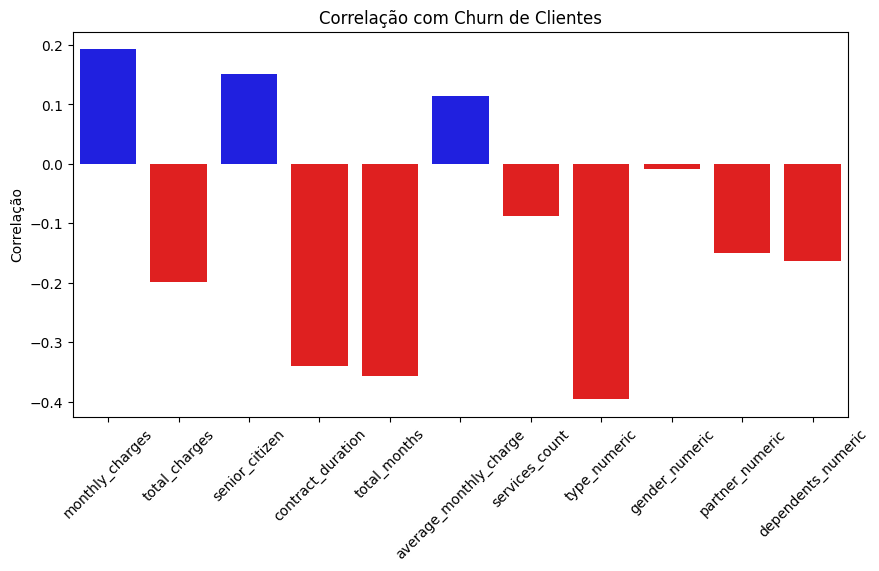

In [21]:
# Selecionar apenas as colunas numéricas, incluindo a nova coluna
numerical_data = merged_data.select_dtypes(include=['float64', 'int64'])
numerical_data['churn'] = merged_data['churn']

# Calcular a matriz de correlação
correlation_matrix = numerical_data.corr()

# Selecionar as correlações com a coluna churn
contract_status_correlations = correlation_matrix['churn'].drop(
    'churn')

# Imprimir as correlações
print("Correlação com a coluna churn:")
print(contract_status_correlations)

# Plotar as correlações
plt.figure(figsize=(10, 5))

# Definir as cores: vermelho para valores negativos, azul para positivos
colors = ['red' if val <
          0 else 'blue' for val in contract_status_correlations.values]

# Criar o gráfico de barras
sns.barplot(x=contract_status_correlations.index,
            y=contract_status_correlations.values, palette=colors)

# Configurar o título e rótulos
plt.title('Correlação com Churn de Clientes')
plt.xticks(rotation=45)
plt.ylabel('Correlação')

# Exibir o gráfico
plt.show()

- monthly_charges (0.192858): 

    Correlação positiva fraca. Clientes com cobranças mensais mais altas tendem a cancelar o contrato com mais frequência.
    

- total_charges (-0.199484): 

    Correlação negativa fraca. Clientes com cobranças totais mais altas são um pouco menos propensos a cancelar, indicando uma possível fidelidade de clientes de longo prazo.
    

- senior_citizen (0.150541): 

    Correlação positiva fraca. Clientes idosos tendem a cancelar contratos ligeiramente mais do que os não idosos.
    

- contract_duration (-0.339587): 

    Correlação negativa moderada. Contratos de longa duração estão associados a menor chance de cancelamento, indicando que contratos mais longos tendem a reter clientes.
    

- total_months (-0.356683): 

    Correlação negativa moderada. Clientes que permaneceram por mais tempo na empresa têm menor probabilidade de cancelar.
    

- average_monthly_charge (0.113929): 

    Correlação positiva fraca. Clientes com uma média de cobrança mensal mais alta têm uma leve tendência a cancelar.
    

- services_count (-0.087882): 

    Correlação negativa muito fraca. O número de serviços contratados tem pouco impacto na decisão de cancelar o contrato.
    

- type_numeric (-0.396150): 

    Correlação negativa moderada. O tipo de contrato tem uma influência significativa, sugerindo que certos tipos de contratos retêm mais clientes.


- gender_numeric (-0.008545): 

    Correlação praticamente nula. O gênero tem um impacto muito pequeno ou insignificante na decisão de cancelamento.

- partner_numeric (-0.149982): 

    Correlação negativa fraca. Clientes com parceiro são um pouco menos propensos a cancelar o contrato, o que pode refletir maior estabilidade ou fidelidade.
    

- dependents_numeric (-0.163128): 

    Correlação negativa fraca. Clientes com dependentes tendem a cancelar um pouco menos do que aqueles sem dependentes, o que pode sugerir que esses clientes têm compromissos maiores e, possivelmente, são mais fiéis.
    
    

* **Conclusão:**

    - Fatores como contract_duration e total_months são os melhores indicadores de retenção, já que quanto mais tempo o cliente tem contrato, menor a chance de churn.
    - type_numeric também desempenha um papel importante, sugerindo que o tipo de contrato é um dos fatores mais fortes na retenção de clientes.
    - Características pessoais como gender_numeric, partner_numeric, e dependents_numeric têm correlação fraca, mas clientes com parceiro e dependentes tendem a cancelar menos do que os outros. O gênero tem impacto mínimo.

- Verificar a distribuição de clientes que cancelaram versus os que permaneceram.
- Explorar as correlações entre variáveis como tempo de contrato, serviços contratados e churn.


Análise de Churn para gender_numeric:
    gender_numeric  churn_rate  total_churn  count
0               0    0.269595          939   3483
1               1    0.262046          930   3549


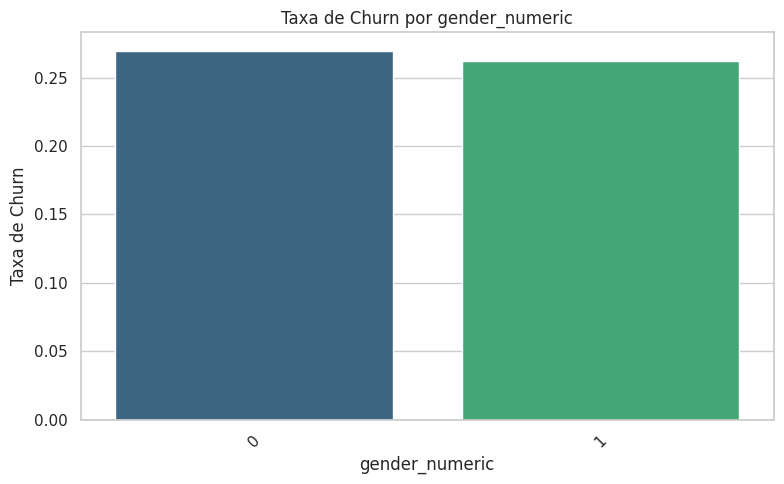

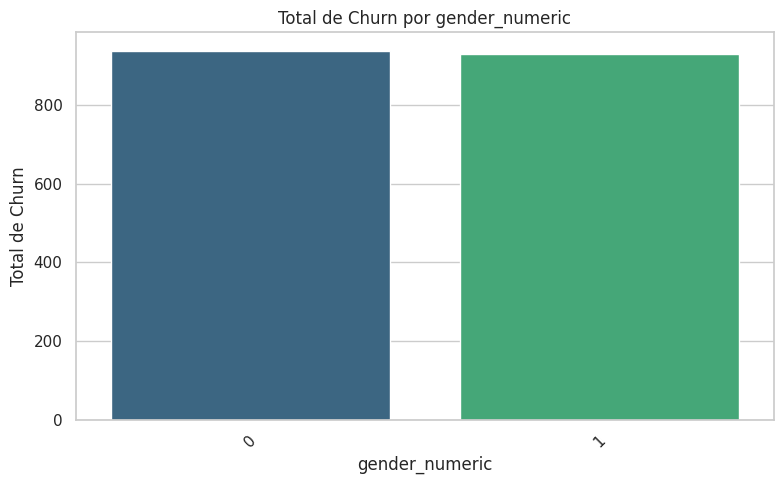


Análise de Churn para partner_numeric:
    partner_numeric  churn_rate  total_churn  count
0                0    0.329761         1200   3639
1                1    0.197171          669   3393


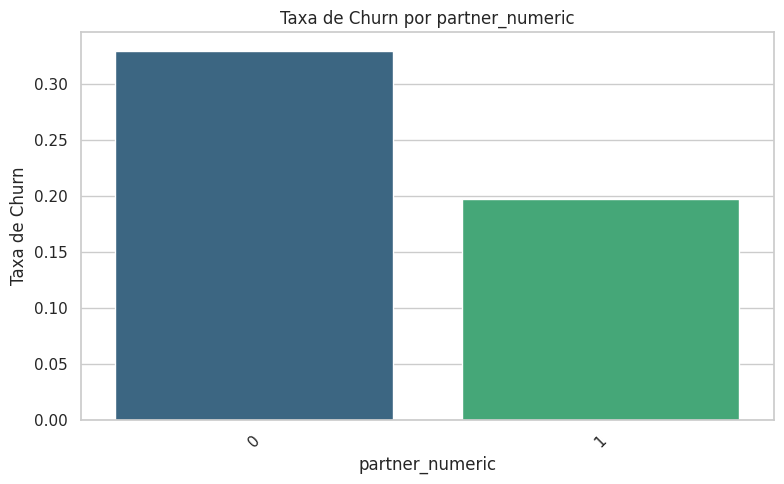

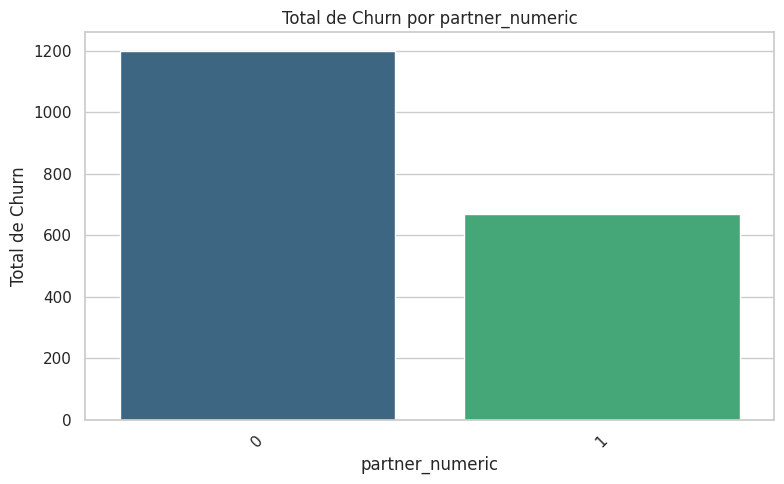


Análise de Churn para dependents_numeric:
    dependents_numeric  churn_rate  total_churn  count
0                   0    0.312791         1543   4933
1                   1    0.155312          326   2099


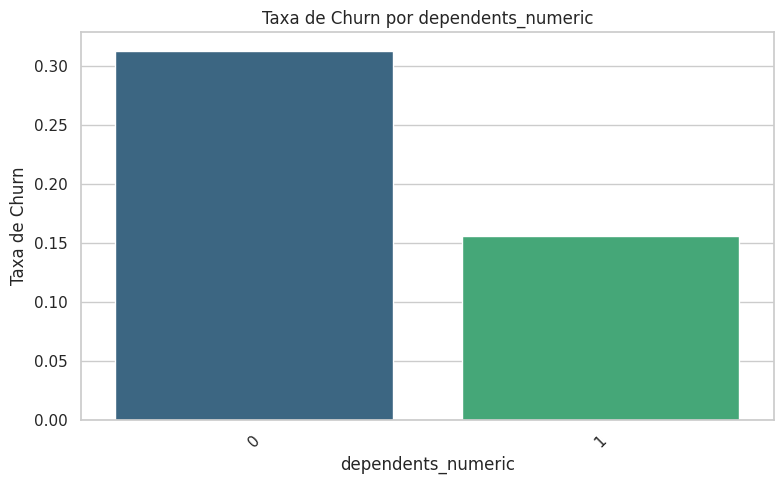

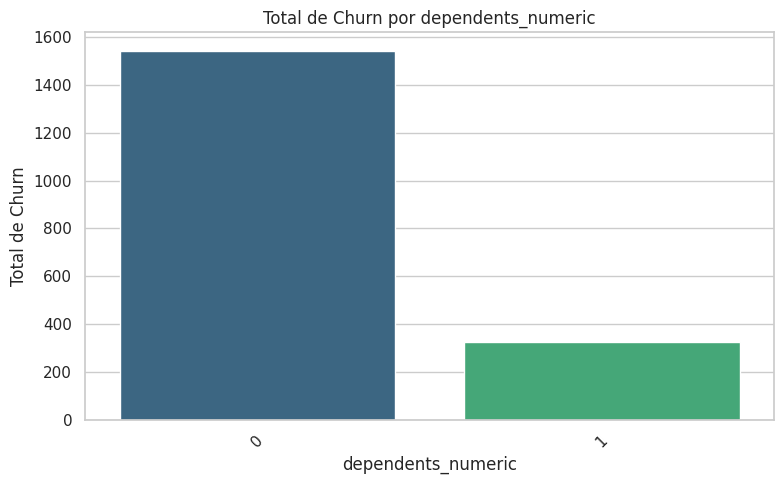


Análise de Churn para monthly_charges em Buckets:
   monthly_charges_bucket  churn_rate
0       (18.249, 35.588]    0.113197
1        (35.588, 70.35]    0.245883
2        (70.35, 89.862]    0.375499
3       (89.862, 118.75]    0.328783


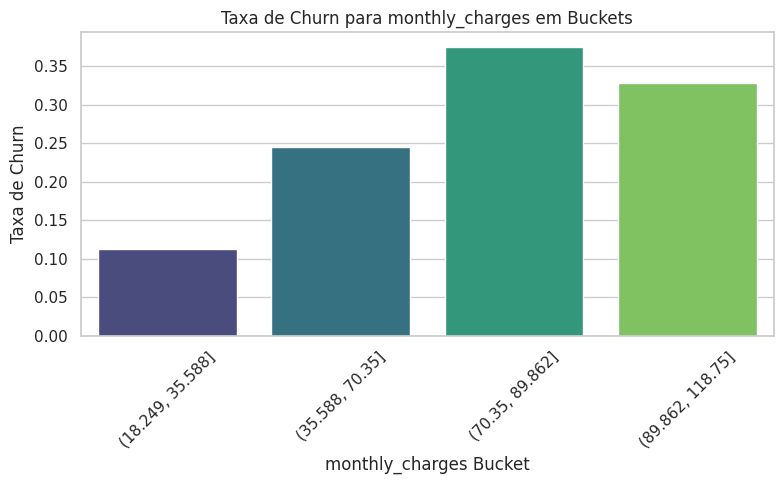


Análise de Churn para total_charges em Buckets:
    total_charges_bucket  churn_rate
0      (18.799, 401.45]    0.434585
1    (401.45, 1397.475]    0.253129
2  (1397.475, 3794.738]    0.230375
3    (3794.738, 8684.8]    0.145051


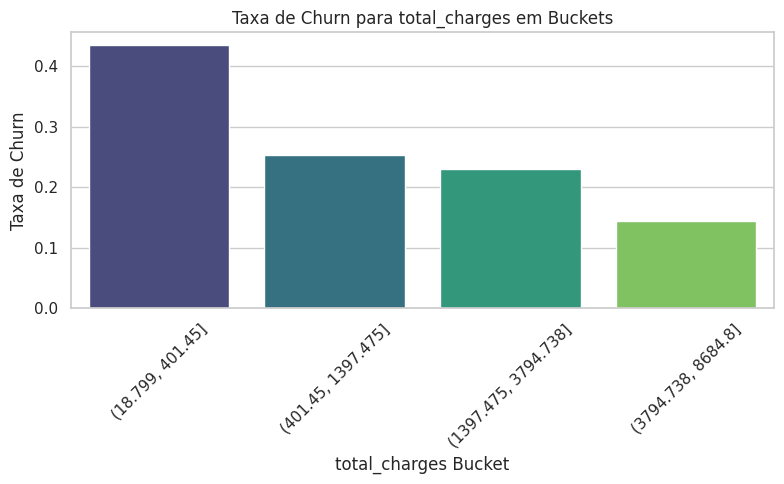


Análise de Churn para contract_duration em Buckets:
   contract_duration_bucket  churn_rate
0             (0.999, 9.0]    0.488036
1              (9.0, 29.0]    0.296105
2             (29.0, 56.0]    0.187916
3             (56.0, 74.0]    0.080712


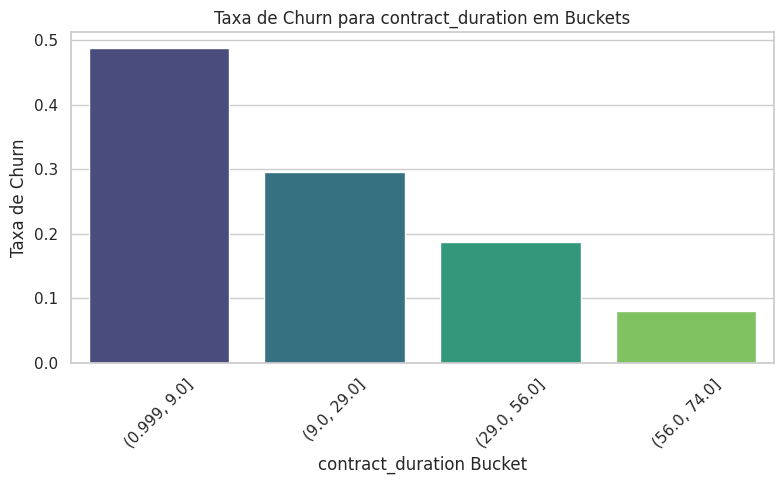


Análise de Churn para total_months em Buckets:
   total_months_bucket  churn_rate
0       (0.999, 52.0]    0.329452
1        (52.0, 74.0]    0.067330


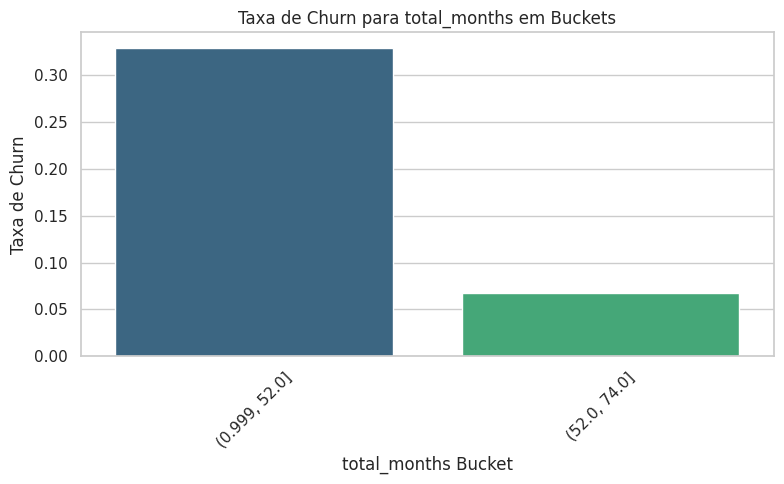


Análise de Churn para average_monthly_charge em Buckets:
   average_monthly_charge_bucket  churn_rate
0                (9.432, 57.58]    0.123436
1              (57.58, 103.433]    0.213311
2            (103.433, 853.025]    0.349261
3             (853.025, 8061.5]    0.377133


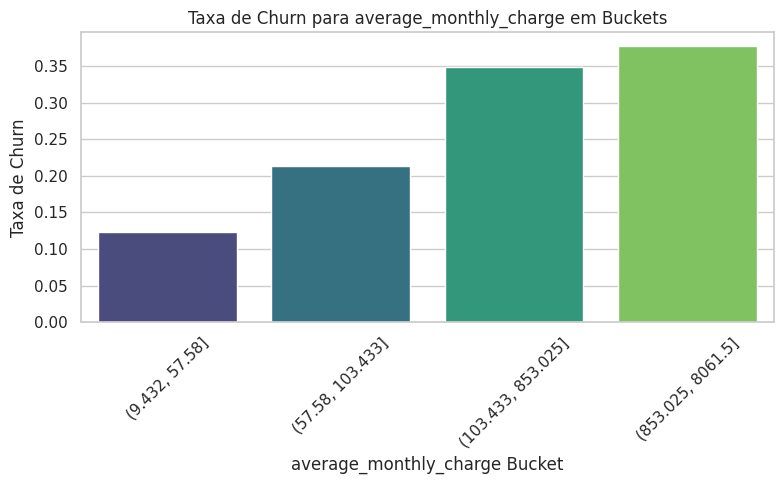


Análise de Churn para services_count em Buckets:
   services_count_bucket  churn_rate
0         (-0.001, 2.0]    0.305556
1            (2.0, 3.0]    0.273948
2            (3.0, 6.0]    0.162067


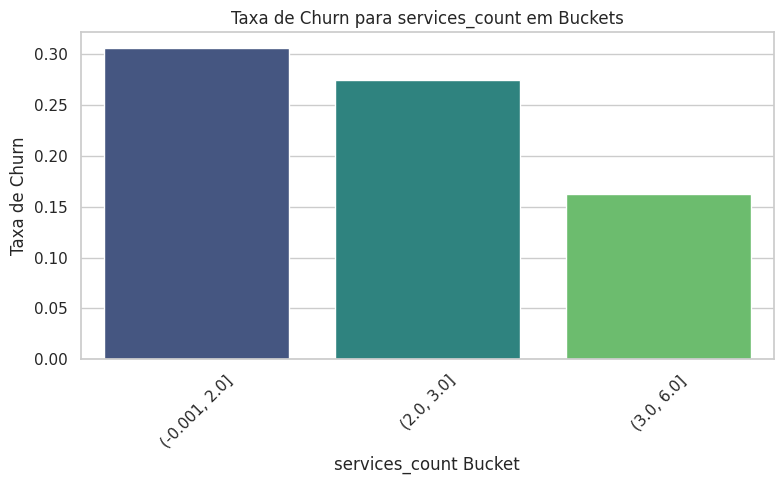

In [22]:
# Configurações para os gráficos
sns.set(style="whitegrid")

# Calcular a taxa de churn e a quantidade absoluta para variáveis categóricas
categorical_vars = ['gender_numeric', 'partner_numeric', 'dependents_numeric']

for var in categorical_vars:
    churn_analysis = merged_data.groupby(var)['churn'].agg(['mean', 'sum', 'count']).reset_index()
    churn_analysis.columns = [var, 'churn_rate', 'total_churn', 'count']
    print(f"\nAnálise de Churn para {var}:\n", churn_analysis)

    # Gráfico de barras para taxa de churn
    plt.figure(figsize=(8, 5))
    sns.barplot(x=var, y='churn_rate', data=churn_analysis, palette='viridis')
    plt.title(f'Taxa de Churn por {var}')
    plt.ylabel('Taxa de Churn')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Gráfico de barras para total de churn
    plt.figure(figsize=(8, 5))
    sns.barplot(x=var, y='total_churn', data=churn_analysis, palette='viridis')
    plt.title(f'Total de Churn por {var}')
    plt.ylabel('Total de Churn')
    plt.xlabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Definir as variáveis numéricas que você deseja analisar
numeric_vars = ['monthly_charges', 'total_charges', 'contract_duration', 'total_months', 'average_monthly_charge', 'services_count']

# Analisar a taxa de churn em buckets para variáveis numéricas
for var in numeric_vars:
    try:
        # Criar buckets usando pd.qcut, permitindo que os limites duplicados sejam descartados
        merged_data[f'{var}_bucket'] = pd.qcut(merged_data[var], q=4, duplicates='drop')
        
        # Calcular a taxa de churn para cada bucket
        churn_analysis_numeric = merged_data.groupby(f'{var}_bucket')['churn'].mean().reset_index()
        churn_analysis_numeric.columns = [f'{var}_bucket', 'churn_rate']
        
        print(f"\nAnálise de Churn para {var} em Buckets:\n", churn_analysis_numeric)

        # Gráfico de barras para taxa de churn em buckets
        plt.figure(figsize=(8, 5))
        sns.barplot(x=f'{var}_bucket', y='churn_rate', data=churn_analysis_numeric, palette='viridis')
        plt.title(f'Taxa de Churn para {var} em Buckets')
        plt.ylabel('Taxa de Churn')
        plt.xlabel(f'{var} Bucket')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Erro ao processar {var}: {e}")

# Análise de Churn

## Análise de Churn para Variáveis Categóricas

1. **`gender_numeric`**:
   - **Taxa de churn**:
     - Masculino (0): 26.96%
     - Feminino (1): 26.20%
   - **Interpretação**: A taxa de churn é bastante semelhante entre os gêneros, com uma ligeira tendência maior para homens, mas a diferença não é significativa.

2. **`partner_numeric`**:
   - **Taxa de churn**:
     - Sem parceiro (0): 32.98%
     - Com parceiro (1): 19.72%
   - **Interpretação**: Aqueles sem parceiro têm uma taxa de churn consideravelmente maior, o que sugere que ter um parceiro pode estar associado a maior retenção de clientes.

3. **`dependents_numeric`**:
   - **Taxa de churn**:
     - Sem dependentes (0): 31.28%
     - Com dependentes (1): 15.53%
   - **Interpretação**: Assim como no caso de parceiros, a presença de dependentes está associada a uma menor taxa de churn, indicando que clientes com dependentes podem ser mais leais.

## Análise de Churn para Variáveis Numéricas em Buckets

1. **`monthly_charges`**:
   - **Buckets**:
     - (18.25, 35.59]: 11.32%
     - (35.59, 70.35]: 24.59%
     - (70.35, 89.86]: 37.55%
     - (89.86, 118.75]: 32.88%
   - **Interpretação**: A taxa de churn aumenta conforme os encargos mensais aumentam, com o maior churn observado no bucket entre 70.35 e 89.86. Isso pode indicar que clientes que pagam mais estão insatisfeitos com os serviços.

2. **`total_charges`**:
   - **Buckets**:
     - (18.80, 401.45]: 43.46%
     - (401.45, 1397.48]: 25.31%
     - (1397.48, 3794.74]: 23.04%
     - (3794.74, 8684.80]: 14.51%
   - **Interpretação**: A taxa de churn é extremamente alta para aqueles com menores encargos totais (43.46%), sugerindo que os clientes que gastaram menos podem ter percebido menos valor ou estavam insatisfeitos, levando à sua saída.

3. **`contract_duration`**:
   - **Buckets**:
     - (0.999, 9.0]: 48.80%
     - (9.0, 29.0]: 29.61%
     - (29.0, 56.0]: 18.79%
     - (56.0, 74.0]: 8.07%
   - **Interpretação**: Clientes com contratos mais curtos têm uma taxa de churn muito maior, indicando que a fidelidade tende a aumentar com a duração do contrato.

4. **`total_months`**:
   - **Buckets**:
     - (0.999, 52.0]: 32.95%
     - (52.0, 74.0]: 6.73%
   - **Interpretação**: Uma diminuição drástica na taxa de churn após 52 meses sugere que clientes mais antigos são muito mais propensos a permanecer.

5. **`average_monthly_charge`**:
   - **Buckets**:
     - (9.43, 57.58]: 12.34%
     - (57.58, 103.43]: 21.33%
     - (103.43, 853.03]: 34.93%
     - (853.03, 8061.50]: 37.71%
   - **Interpretação**: Taxas de churn aumentam com os encargos médios mensais. Clientes que pagam mais em média estão mais propensos a sair.

6. **`services_count`**:
   - **Buckets**:
     - (-0.001, 2.0]: 30.56%
     - (2.0, 3.0]: 27.39%
     - (3.0, 6.0]: 16.21%
   - **Interpretação**: Clientes que utilizam menos serviços têm taxas de churn mais altas, indicando que um maior número de serviços pode estar relacionado a uma maior satisfação e retenção.

## Resumo Geral
A análise revela padrões importantes sobre como diferentes características dos clientes e seus hábitos de consumo influenciam a taxa de churn. Em geral, clientes sem parceiro ou dependentes tendem a ter taxas de churn mais altas. Além disso, maiores encargos mensais e menores durações de contrato estão associados a um maior churn. Isso sugere que a satisfação do cliente e a percepção de valor são críticas para a retenção, destacando a importância de estratégias de fidelização, especialmente para aqueles em segmentos mais vulneráveis.

# PERGUNTAS:

1. Esses dados faltantes na coluna de Internet e Telefone são clientes que não utilizam as serviços ou alguma falha no banco de dados?

2. Qual a data da extração dos Dataframes para ajustar os tempos de contratos ativos até o período da extração?


# PRÓXIMOS PASSOS:


### 4. Desenvolvimento de Modelos
- Escolher modelos para predição de churn:
  - Regressão Logística
  - Floresta Aleatória
  - Gradient Boosting
  - Rede Neural (?)
- Dividir os dados em conjunto de treino, validação e teste.
- Treinar e avaliar os modelos usando métricas como AUC, precisão, recall e F1-Score.

### 5. Validação e Otimização
- Ajuste de hiperparâmetros e uso de técnicas como **GridSearchCV** para melhorar o desempenho do modelo.

### 6. Relatório Final
- Preparar um relatório com as principais descobertas, desempenho do modelo e recomendações para a equipe de marketing.
